In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Read in the data and select the columns of interest

data = pd.read_csv('/kaggle/input/policy-claims-data/Joined policies and claims.csv')

df = data[['AgeMainDriver', 'VehicleGroup', 'DrivingRestriction', 'YearsOwned', 'VehicleAge', 'Exposure', 'ClaimsNumberAD']].copy()

In [3]:
# Cap AgeMainDriver at 85

df.AgeMainDriver = df.AgeMainDriver.apply(lambda x: x if x < 85 else 85)

# Fitting a GLM with only simple factors

In [4]:
# Create formula for a Poisson-Log GLM with all factors treated as "simple factors"

# i.e. create a dummy variable for each level of each factor except for the mode of that factor which acts as the baseline

feature_names = ['AgeMainDriver', 'VehicleGroup', 'DrivingRestriction', 'YearsOwned', 'VehicleAge']

formula1 = 'ClaimsNumberAD ~ '

for feature in feature_names:
    if df[feature].dtype == 'object':
        formula1 += f'C({feature}, Treatment(reference="{df[feature].mode()[0]}")) + '
    else:
        formula1 += f'C({feature}, Treatment(reference={df[feature].mode()[0]})) + '

formula1 = formula1.rstrip(' + ')

In [5]:
# Fit Poisson-Log GLM with offset for exposure

model1 = smf.glm(
    data = df,
    formula = formula1,
    offset = np.log(df['Exposure']),
    family = sm.families.Poisson()
)

result1 = model1.fit(
    maxiter=10,
    tol=0.0001
)

## OBS vs CA

In [6]:
# Calculate OBS for Vehicle Age

VehicleAge_OBS = []

for x in sorted(df.VehicleAge.unique()):
    total_claimsnumber = df['ClaimsNumberAD'][df.VehicleAge == x].sum()
    total_exposure = df['Exposure'][df.VehicleAge == x].sum()
    obs = total_claimsnumber/total_exposure
    VehicleAge_OBS.append(obs)

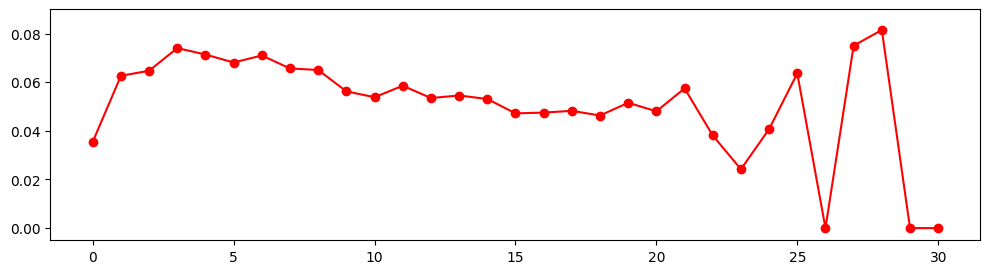

In [7]:
# Plot OBS for Vehicle Age

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAge_OBS, marker='o', color='red')

ax.set_ylim(bottom=-0.005,top=0.09);

In [8]:
# Calculate CA for Vehicle Age

VehicleAge_CA = []

for x in sorted(df.VehicleAge.unique()):
    sum_preds = ((result1.predict(df[df.VehicleAge == x]))*(df['Exposure'][df['VehicleAge']==x])).sum()
    total_exposure = df['Exposure'][df.VehicleAge == x].sum()
    avg_pred = sum_preds/total_exposure
    VehicleAge_CA.append(avg_pred)

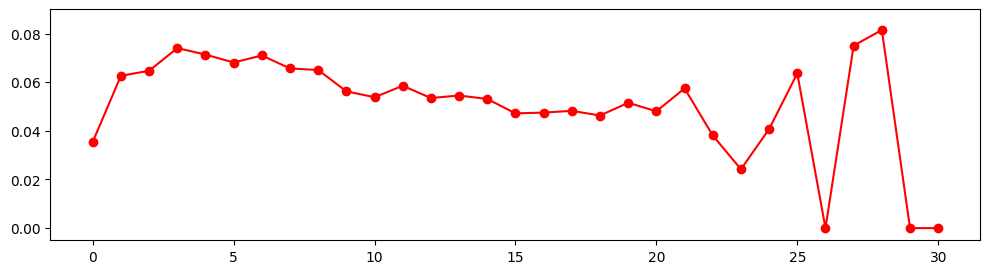

In [9]:
# Plot CA for Vehicle Age

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAge_CA, marker='o', color='red')

ax.set_ylim(bottom=-0.005,top=0.09);

## CM vs CU

In [10]:
# Calculate CM for Vehicle Age

VehicleAge_CM = list(np.exp(result1.params.iloc[141:])*np.exp(result1.params.iloc[0]))

VehicleAge_CM.insert(6,np.exp(result1.params.iloc[0])) # inserting value for baseline level

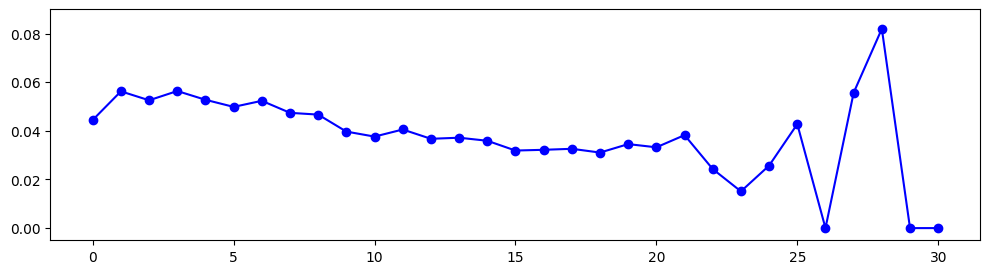

In [11]:
# Plot CM for Vehicle Age

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAge_CM, marker='o', color='blue')

ax.set_ylim(bottom=-0.005, top=0.09);

In [12]:
# Calculate CU for Vehicle Age

VehicleAge_CU = np.array(VehicleAge_CM)*np.array(VehicleAge_OBS)/np.array(VehicleAge_CA)

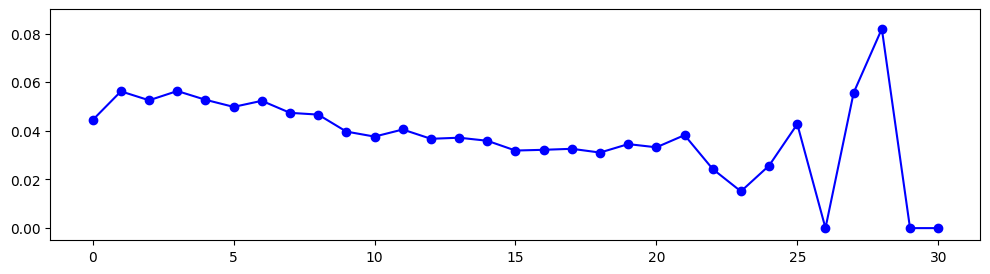

In [13]:
# Plot CU for Vehicle Age

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAge_CU, marker='o', color='blue')

ax.set_ylim(bottom=-0.005, top=0.09);

# Fitting a GLM with Vehicle Age as a degree 1 polynomial factor

In [14]:
# Set "x-values" for VehicleAgeX1

def VA_xval(x):
    return float(x)

df.insert(loc=0, column='VehicleAgeX1', value=df['VehicleAge'].apply(VA_xval))

In [15]:
# Create formula for a Poisson-Log GLM with all factors treated as "simple factors" except for VehicleAge

# We fit VehicleAge as a polynomial factor of degree 1

feature_names2 = ['AgeMainDriver', 'VehicleGroup', 'DrivingRestriction', 'YearsOwned', 'VehicleAgeX1']

formula2 = 'ClaimsNumberAD ~ '

for feature in feature_names2:
    if feature == 'VehicleAgeX1':
        formula2 += 'VehicleAgeX1 + '   
    elif df[feature].dtype == 'object':
        formula2 += f'C({feature}, Treatment(reference="{df[feature].mode()[0]}")) + '
    else:
        formula2 += f'C({feature}, Treatment(reference={df[feature].mode()[0]})) + '

formula2 = formula2.rstrip(' + ')

formula2

'ClaimsNumberAD ~ C(AgeMainDriver, Treatment(reference=56)) + C(VehicleGroup, Treatment(reference=23)) + C(DrivingRestriction, Treatment(reference="IOD")) + C(YearsOwned, Treatment(reference=2)) + VehicleAgeX1'

In [16]:
# Fit Poisson-Log GLM with offset for exposure:

model2 = smf.glm(
    data = df,
    formula = formula2,
    offset = np.log(df['Exposure']),
    family = sm.families.Poisson()
)

result2 = model2.fit(
    maxiter=10,
    tol=0.0001
)

## OBS vs CA

In [17]:
# Calculate CA for VehicleAgeX1

VehicleAgeX1_CA = []

for x in sorted(df.VehicleAge.unique()):
    sum_preds = (result2.predict(df[df.VehicleAgeX1 == VA_xval(x)])*df['Exposure'][df.VehicleAge == x]).sum()
    total_exposure = df['Exposure'][df.VehicleAge == x].sum()
    avg_pred = sum_preds/total_exposure
    VehicleAgeX1_CA.append(avg_pred)

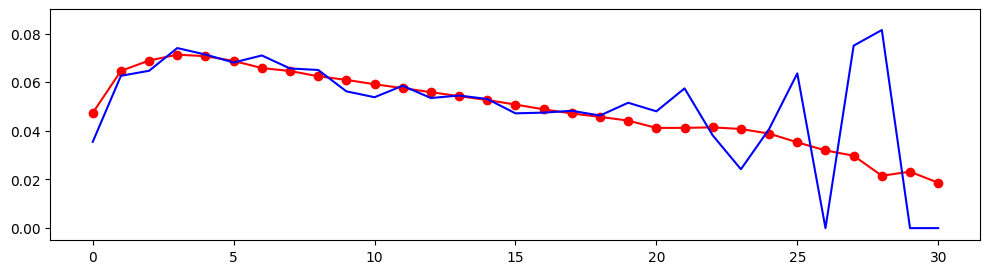

In [18]:
# Plot CA against OBS for VehicleAgeX1

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAgeX1_CA, marker='o', color='red')

ax.plot(sorted(df.VehicleAge.unique()), VehicleAge_OBS, color='blue')

ax.set_ylim(bottom=-0.005,top=0.09);

## CM vs CU

In [19]:
# Calculate CM for VehicleAgeX1

VehicleAgeX1_CM = []

for x in sorted(df.VehicleAge.unique()):
    VehicleAgeX1_CM.append(np.exp(result2.params.iloc[0]+result2.params['VehicleAgeX1']*VA_xval(x)))

In [20]:
# Calculate CU for VehicleAgeX1

VehicleAgeX1_CU = np.array(VehicleAgeX1_CM)*np.array(VehicleAge_OBS)/np.array(VehicleAgeX1_CA)

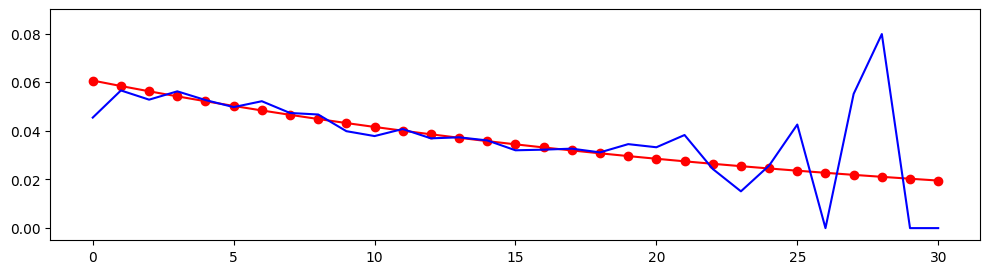

In [21]:
# Plot CM vs CU for VehicleAgeX1

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAgeX1_CM, marker='o', color='red')

ax.plot(sorted(df.VehicleAge.unique()), VehicleAgeX1_CU, color='blue')

ax.set_ylim(bottom=-0.005,top=0.09);

# Fitting a GLM with Vehicle Age as a degree 4 polynomial factor

In [22]:
# Set "x-values" for VehicleAgeX4

def VA_xval4(x):
    if 0 <= x <= 1:
        return float(1)
    elif 2 <= x <= 15:
        return float(x)
    return float(15)

df.insert(loc=0, column='VehicleAgeX4', value=df['VehicleAge'].apply(VA_xval4))

In [23]:
# Create formula for a Poisson-Log GLM with all factors treated as "simple factors" except for VehicleAge

# We fit VehicleAge as a polynomial factor of degree 4

feature_names3 = ['AgeMainDriver', 'VehicleGroup', 'DrivingRestriction', 'YearsOwned', 'VehicleAgeX4']

formula3 = 'ClaimsNumberAD ~ '

for feature in feature_names3:
    if feature == 'VehicleAgeX4':
        formula3 += 'VehicleAgeX4 + np.power(VehicleAgeX4,2) + np.power(VehicleAgeX4,3) + np.power(VehicleAgeX4,4) + '   
    elif df[feature].dtype == 'object':
        formula3 += f'C({feature}, Treatment(reference="{df[feature].mode()[0]}")) + '
    else:
        formula3 += f'C({feature}, Treatment(reference={df[feature].mode()[0]})) + '

formula3 = formula3.rstrip(' + ')

formula3

'ClaimsNumberAD ~ C(AgeMainDriver, Treatment(reference=56)) + C(VehicleGroup, Treatment(reference=23)) + C(DrivingRestriction, Treatment(reference="IOD")) + C(YearsOwned, Treatment(reference=2)) + VehicleAgeX4 + np.power(VehicleAgeX4,2) + np.power(VehicleAgeX4,3) + np.power(VehicleAgeX4,4)'

In [24]:
# Fit Poisson-Log GLM with offset for exposure:

model3 = smf.glm(
    data = df,
    formula = formula3,
    offset = np.log(df['Exposure']),
    family = sm.families.Poisson()
)

result3 = model3.fit(
    maxiter=10,
    tol=0.0001
)

## OBS vs CA

In [25]:
# Calculate CA for VehicleAgeX4

VehicleAgeX4_CA = []

for x in sorted(df.VehicleAge.unique()):
    sum_preds = (result3.predict(df[df.VehicleAgeX4 == VA_xval4(x)])*df['Exposure'][df.VehicleAge == x]).sum()
    total_exposure = df['Exposure'][df.VehicleAge == x].sum()
    avg_pred = sum_preds/total_exposure
    VehicleAgeX4_CA.append(avg_pred)

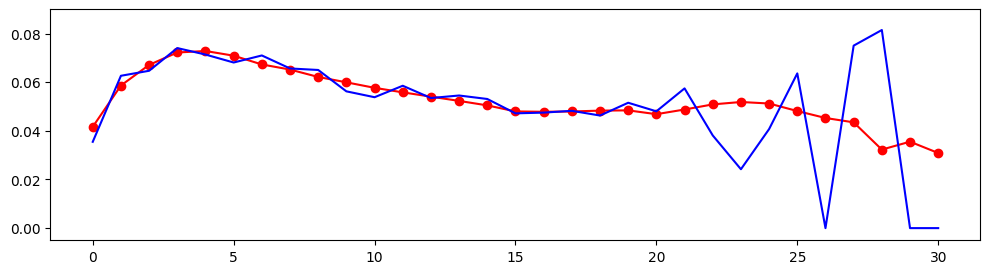

In [26]:
# Plot CA against OBS for VehicleAgeX4

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAgeX4_CA, marker='o', color='red')

ax.plot(sorted(df.VehicleAge.unique()), VehicleAge_OBS, color='blue')

ax.set_ylim(bottom=-0.005,top=0.09);

## CM vs CU

In [27]:
# Calculate CM for VehicleAgeX4

VehicleAgeX4_CM = []

for x in sorted(df.VehicleAge.unique()):
    poly = result3.params['VehicleAgeX4']*VA_xval4(x)
    for i in [2,3,4]:
        poly += result3.params[f'np.power(VehicleAgeX4, {i})']*VA_xval4(x)**i
    VehicleAgeX4_CM.append(np.exp(result3.params.iloc[0]+poly))

In [28]:
# Calculate CU for VehicleAgeX4

VehicleAgeX4_CU = np.array(VehicleAgeX4_CM)*np.array(VehicleAge_OBS)/np.array(VehicleAgeX4_CA)

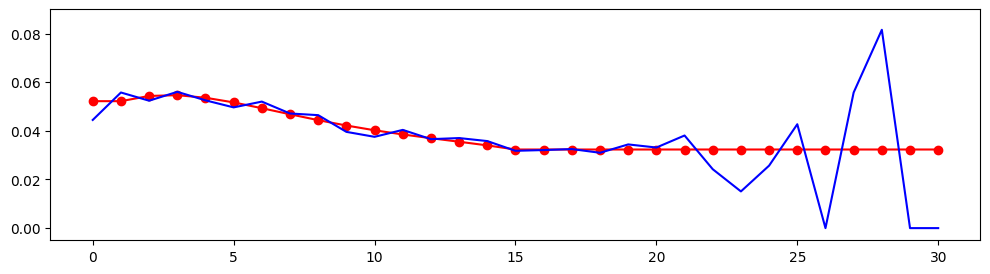

In [29]:
# Plot CM vs CU for VehicleAgeX4

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(sorted(df.VehicleAge.unique()), VehicleAgeX4_CM, marker='o', color='red')

ax.plot(sorted(df.VehicleAge.unique()), VehicleAgeX4_CU, color='blue')

ax.set_ylim(bottom=-0.005,top=0.09);